In [106]:
# Import needed libraries
import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt
from integral_constraints import C, C_dx, C_dy, K, K_dvx, K_dvy, K_ddelta
import os

# 1. Introduction

### Abstract

Efficient pathfinding is a critical aspect of competitive racing across various disciplines, including marathons, cycling tours, and Formula 1 events. This paper delves into the pursuit of identifying optimal trajectories for completing laps on NASCAR tracks with the primary objective of minimizing lap times. A key consideration in achieving high speeds on such tracks is the ability to navigate turns effectively, as exceeding the optimal speed threshold can compromise traction and stability, leading to undesirable outcomes such as skidding or flipping. The concept of the racing line, which involves maximizing turn radii by starting on the outside, hitting the apex, and finishing on the outside of a turn, plays a pivotal role in this endeavor.

Through a comprehensive analysis, this study integrates principles of optimal control, vehicle steering dynamics, and friction constraints to formulate strategies for determining the fastest path around a NASCAR track. By leveraging these methodologies, we aim to enhance our understanding of the complex interplay between driving dynamics and track geometry, ultimately contributing to the advancement of racing performance and strategy. The findings presented herein offer insights into the intricacies of path optimization in high-speed racing environments and lay the groundwork for further research in this domain.

# 2. Background 

### Problem Description

At first glance, it may seem straightforward to determine the best path for a racecar around an F-1 track by solely controlling its acceleration in the x and y directions. However, this naive approach overlooks important real-world factors.

In reality, steering dynamics and the limited traction available to prevent sliding or flipping are crucial considerations in finding the optimal path. To accurately represent this, we must incorporate these physical constraints, including introducing another control for steering wheel turn acceleration, which must be managed to maintain sufficient traction.

In our study, we compared two methods: one using a naive approach and the other considering traction constraints. Through this comparison, we aimed to illustrate how the car's navigation around the track differs under these conditions. This highlights the significance of addressing real-world complexities when optimizing racing paths.



### Relevant Research

Many have formed mathematical models for the motion of automobiles in a variety of settings including optimal control. A common choice for modeling the motion of an automobile is the Kinematic Bicycle Model which simplifies the dynamics of an automobile. Victor Freire and Xiangru Xu, for example, used the Kinematic Bicycle Model when solving an optimal control problem for maximizing the safety of automobile trips [1]. In addition, Limebeer, Bastin, Warren, & Fensham employed the Kinematic Bicycle Model in their optimal control problem for NASCAR race cars [2]. In accordance with this research, we also use the Kinematic Bicycle Model to simplify the control problem without deviating too far from real world kinematics. We outline the application of the Kinematic Bicycle Model to our optimal control problem below. 

# 3. Mathematical Representation

### The Setup

We first defined the variables for the representation of a car going around an F-1 racetrack as:

\begin{align*}
x &= \text{x position} \\
y &= \text{y position} \\
v_x &= \text{x velocity} \\
v_y &= \text{y velocity} \\
\theta &= \text{vehicle orientation with respect to the x-axis} \\
\delta &= \text{angle of front wheels with respect to the vehicle's orientation} \\
L &= \text{Length of car measured from front wheel axis to back wheel axis} \\
M &= \text{maximum allowable centripetal acceleration} \\
u_{\text{acc}} &= \text{acceleration} \\
u_{\text{angle}} &= \text{change in steering angle}
\end{align*}

where $u_{acc}$ and $u_{angle}$ are our control variables.

We defined our state equations as follows:

$\begin{bmatrix}
\dot{x} \\
\dot{y} \\
\dot{v}_x \\
\dot{v}_y \\
\dot{\theta} \\
\dot{\delta} \\
\end{bmatrix} = \begin{bmatrix}
    v_x \\
    v_y \\
    u_{acc} \cdot \cos(\theta) \\
    u_{acc} \cdot \sin(\theta) \\
    \sqrt{{v_x}^2 + {v_y}^2} \cdot \frac{\tan(\delta)}{L} \\
    u_{angle}
\end{bmatrix}$


With an unmodified cost functional of 

$J[u] = \int\limits_0^{t_f}dt$ 


Using the fact that centripetal acceleration is $\frac{v^2}{r}$ where $r$ is the turn radius which is dependent on $L$, we arive at our centripetal acceleration constraint:

$\frac{{v_x}^2 + {v_y}^2}{L}\tan(\delta) - M < 0$

And finally we have the constraints of the race track:

$(x-1)^2+y^2>1$,  
$(x+1)^2+y^2>1$, and  
$|y|>1$ when $|x|<1$

# 4. Derivation of Solution

### Deriving the Modified Cost Functional

We enforce the constraints above by defining functions with extremely high penalties for violating the constraints and including these functions in the cost functional. We first define the function that describes the topology of the racetrack, penalizing heavily for movement inside and outside the track:

$C(x,y) = \frac{3}{(\frac{x^2}{15} + \frac{y^2}{10})^{20} + 1}
-\frac{3}{(\frac{x^2}{10} + \frac{y^2}{5})^{70} + 1}
+\frac{3}{((x-1)^2 + y^2)^{20} + 1}
+\frac{3}{((x+1)^2 + y^2)^{20} + 1}
+\frac{3}{(x^2 + y^2)^{20} + 1}$

Next, we define the function that gives a severe penalty for violating the centripetal acceleration constraint:

$K(v_x, v_y, \delta) = \left(\frac{1}{\frac{{v_x}^2 + {v_y}^2}{L}\tan(\delta) - M} \right)^{70}$

We then define a function that penalizes unreasonably high acceleration values:

$W(u_{acc}, u_{angle}) = w_1{u_{acc}}^2 + w_2{u_{angle}}^2$

Finally, we incorporate all of these penalties into our new cost functional:

$J[u] = \int\limits_0^{t_f} 1 + C(x,y) + K(v_x, v_y, \delta) + W(u_{acc}, u_{angle})dt$ 



### The Hamiltonian, Co-State Equations, and Boundary Equations


Starting with $H = p \cdot f - L$, our full hamiltonian for this problem is:

$H = p_1v_x + p_2v_y + p_3u_{acc}\cos(\theta) + p_4u_{acc}\sin(\theta) + p_5\sqrt{v_x^2 + v_y^2}\frac{\tan(\delta)}{L} + p_6u_{angle} - (1 + C(x,y) + K(v_x, v_y, \delta) + W(u_{acc}, u_{angle}))$

Using this Hamiltonian and applying Pontryagin's Maximum Principle, we obtain the costate equations:

$\begin{bmatrix}
\dot{p_1} \\
\dot{p_2} \\
\dot{p_3} \\
\dot{p_4} \\
\dot{p_5} \\
\dot{p_6} \\
\end{bmatrix} =
\begin{bmatrix}
C_x \\
C_y \\
-p_1 - p_5\frac{v_x}{\sqrt{v_x^2 + v_y^2}}\frac{\tan(\delta)}{L} + K_{v_x}\\
-p_2 - p_5\frac{v_y}{\sqrt{v_x^2 + v_y^2}}\frac{\tan(\delta)}{L} + K_{v_y}\\
p_3u_{acc}\sin(\theta) - p_4u_{acc}\cos(\theta) \\
-\frac{p_5}{L}\sqrt{v_x^2 + v_y^2}\sec^{2}(\delta) + K_{\delta} \\
\end{bmatrix}$


The boundary conditions that we set for both the naive and with the centripetal acceleration constraint models are:

\begin{align*}
x(t_0) &= \begin{bmatrix} -1 & -1.1 & 0 & 0 & 0 & 0 \end{bmatrix} \\
x_{\text{pos}}(t_f), y_{\text{pos}}(t_f) &= \begin{bmatrix} 1 & 1.1 \end{bmatrix} \\
p(t_f) &= \begin{bmatrix} \cdot & \cdot & 0 & 0 & 0 & 0 \end{bmatrix} \\
H(t_f) &= 0
\end{align*}





# 5. Interpretations

### Naive Approach

We initially tested the naive approach, neglecting the traction constraint, and found success when the initial conditions were appropriately set. However, when initialized to ones (a scenario lacking physical sense), we observed erratic paths that failed to function properly. Setting the initial conditions for a straight path through the track resulted in a local minimum, trapping the optimal control and producing an illegal, straight trajectory through the track. Ultimately, initializing the conditions with a non-optimal path around the track prompted the optimal control to correct the trajectory, aligning it with the optimal path around the track.

Note that in these tests we do half a lap around the track with the assumption that the same trajectory can be followed on the other half of the track.

### Experiment 1: Initial Guess of All Ones

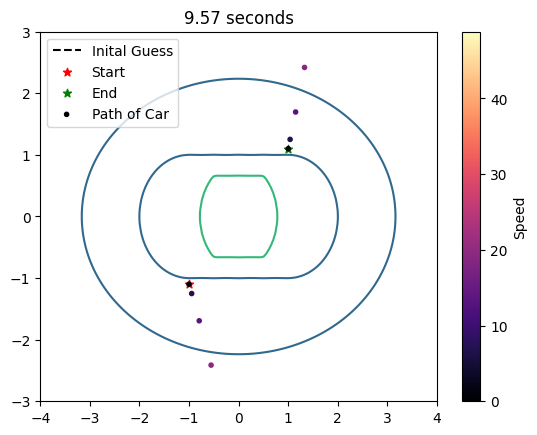

9.572221811380894

In [107]:
naive_system(W1=200, W2=.02, p0=.5, path_x=np.ones(200), path_y=np.ones(200))

The solver needs more coaching in order to find a reasonable solution.

### Experiment 2: Initial Guess of Going Straight Through the Track

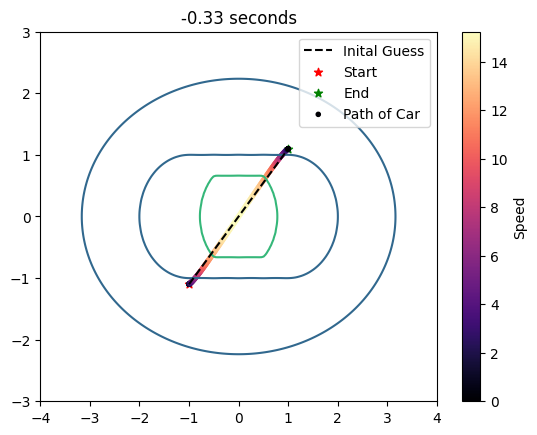

-0.32583985357662826

In [117]:
naive_system(W1=200, W2=.02, p0=.5, path_x=np.linspace(-1.1,1.1,200), path_y=np.linspace(-1, 1, 200))

The solver is unable to escape the center of the track.

### Experiment 3: Initial Guess That Avoids Edges of The Track

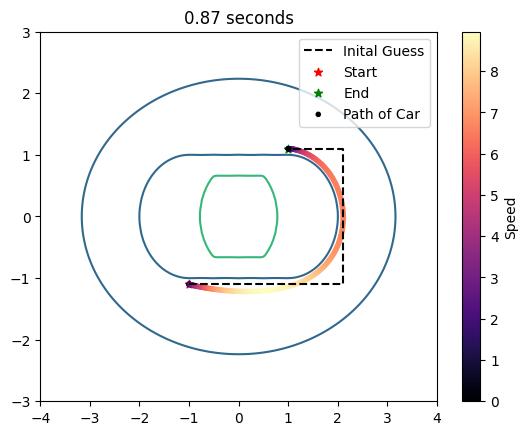

0.8714815722715371

In [116]:
path_x=np.concatenate((np.linspace(-1, 2.1, 100), 2.1*np.ones(75), np.linspace(1, 2.1, 25)[::-1]))
path_y=np.concatenate((-1.1*np.ones(100), np.linspace(-1.1,1.1,75), 1.1*np.ones(25)))
naive_system(W1 = 100,W2 = 0.02,p0 = 0.5,path_x=path_x,path_y=path_y)

The car takes a wide turn, which lets it keep a high velocity, but does slow down a bit on the turn, accelerating as it comes out of the turn.

### Complex Approach with Centripetal Acceleration Constraint

We implemented the complete state equations described above, incorporating the penalty for centripetal acceleration, which yielded more intriguing outcomes. However, the sensitivity of our modeling decisions to initial conditions and weights led to overflow in the derivatives of our constraints. To address this issue, we conducted a grid search with a wide range of weights. After thorough exploration, we identified a few sets of weights that generated the best trajectories. These particular configurations of weights led to the following trajectories:

C:\Users\legit\AppData\Local\Temp\ipykernel_40996\980818605.py:17: RuntimeWarning: invalid value encountered in divide
  -y[6] - y[10] * (y[2] /v * np.tan(y[5]) / L) + K_dvx(y[5], y[2], y[3],L=L,M=M),
C:\Users\legit\AppData\Local\Temp\ipykernel_40996\980818605.py:18: RuntimeWarning: invalid value encountered in divide
  -y[7] - y[10] * (y[3] /v * np.tan(y[5]) / L) + K_dvy(y[5], y[2], y[3],L=L,M=M),


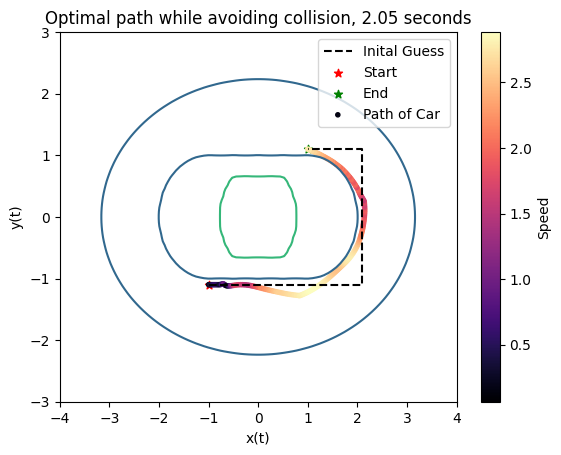

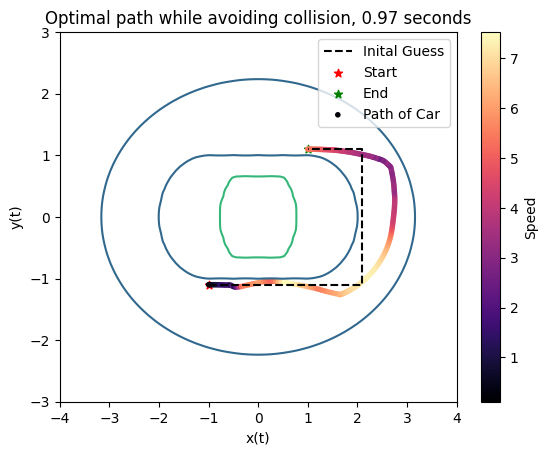

In [110]:
complex_system(W1=1, W2=68/19,L=22.03/14,M=400)
complex_system(W1=1, W2=68/19,L=22.03/14,M=1600/11)

## Conclusions

The first plot above depicts the trajectory of the complex system, closely resembling the path of the naive approach as it hugs the inner wall of the track. However, since the complex system represents a full set of controls accurate to the operation of a race car, it results in a slower time than the naive approach as the car has to slow down a lot more during the turn. This is because a car couldn't perfectly follow the naive approach trajectory with the same velocities as it was generated using arbitrary acceleration in both the x and the y direction, a mechanic not realistic to how cars drive. Our full solution provides a full set of driving mechanics including acceleration, braking, and turning the wheel. The result was slower than the naive approach because of the centripetal acceleration constraint, as expected.

The trajectory in the second plot aligns more closely with our predictions based on the centripetal acceleration constraint. The car swings wide, allowing for more acceleration and speed before slowing down near the end of the turn. This trajectory results in a faster time compared to following the naive path with complex constraints. However, it still has a slightly slower time than the naive approach without the centripetal acceleration constraint.

These models provide meaningful insight into the process of finding the optimal path around a racetrack and the controls necessary to attain that trajectory. Numerical stability plays a major role in modeling decisions such as how to enforce constraints. Future research could pursue more numerically stable ways to design the track and the steering constraints, as well as pathfinding for different track shapes such as those found in Formula 1 races.

# 6. Appendix

[1] V. Freire and X. Xu, "Optimal Control for Kinematic Bicycle Model With Continuous-Time Safety Guarantees: A Sequential Second-Order Cone Programming Approach," in IEEE Robotics and Automation Letters, vol. 7, no. 4, pp. 11681-11688, Oct. 2022

[2] Limebeer, D.J.N., Bastin, M., Warren, E., & Fensham, H. G. (2023). Optimal control of a NASCAR - specification race car. Vehicle System Dynamics, 61(5), 1210-1235


### Additional Functions

In [111]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_bvp

def obstacle(x,y,W1=1,r=(1,1),c=(0,0)):
    '''
    Define an area that will represent an obstacle
    
    Parameters:
        x (float): x position in space
        y (float): y position in space
        W1 (float): weight of cost
        r (tuple): radius in x and y direction
        c (tuple): center of the ellipse
    '''

    ellipse = ((x - c[0])**2/r[0] + (y - c[1])**2/r[1])**20 + 1

    return W1 / ellipse

def obstacle_dx(x,y,W1=1,r=(1,1,),c=(0,0)):
    '''
    x derivative of the obstacle

    Parameters:
        x (float): x position in space
        y (float): y position in space
        W (float): weight of cost
        r (tuple): radius in x and y direction
        c (tuple): center of the ellipse
    '''

    circle = (x - c[0])**2/r[0] + (y - c[1])**2/r[1]
    numer = -40* W1 * (x-c[0])*(circle)**19
    denom = r[0]*((circle)**20 + 1)**2

    return numer / denom

def obstacle_dy(x,y,W1=1,r=(1,1,),c=(0,0)):
    '''
    y derivative of the obstacle

    Parameters:
        x (float): x position in space
        y (float): y position in space
        W1 (float): weight of cost
        r (tuple): radius in x and y direction
        c (tuple): center of the ellipse
    '''

    circle = (x - c[0])**2/r[0] + (y - c[1])**2/r[1]
    numer = -40 * W1 * (y-c[1])*(circle)**19
    denom = r[1]*((circle)**20 + 1)**2

    return numer / denom

def C(x, y, W1=1):
    '''
    Uses the obstacle function to combine all of our ellipses that we used to make our track
    '''
    return obstacle(x, y, 3*W1, r=(100,100)) - obstacle(x, y, W1,r=(10,5)) + obstacle(x, y, W1) + obstacle(x, y, W1, c=(1,0)) + obstacle(x, y, W1, c=(-1,0)) + obstacle(x, y, W1, c=(.5,0)) + obstacle(x, y, W1, c=(-.5,0))

def C_dx(x, y, W1=1):
    '''
    derivative with respect to x of the C function
    '''
    return obstacle_dx(x, y, 3*W1, r=(100,100)) - obstacle_dx(x, y, W1,r=(10,5)) + obstacle_dx(x, y, W1) + obstacle_dx(x, y, W1, c=(1,0)) + obstacle_dx(x, y, W1, c=(-1,0)) + obstacle_dx(x, y, W1, c=(.5,0)) + obstacle_dx(x, y, W1, c=(-.5,0))

def C_dy(x, y, W1=1):
    ''' 
    derivative with respect to y of the C function 
    '''
    return obstacle_dy(x, y, 3*W1, r=(100,100)) - obstacle_dy(x, y, W1,r=(10,5)) + obstacle_dy(x, y, W1) + obstacle_dy(x, y, W1, c=(1,0)) + obstacle_dy(x, y, W1, c=(-1,0)) + obstacle_dy(x, y, W1, c=(.5,0)) + obstacle_dy(x, y, W1, c=(-.5,0))

def K(delta, vx, vy, lmb = 20, cushion=.1, L = .05, M = 3.):
    '''Integral constraint due to centripetal acceleration'''
    return (cushion / (delta - np.arctan(L*M/(vx**2 + vy**2)))) ** lmb

def K_dvx(delta, vx, vy, lmb=20, cushion=.1, L=.05, M=3.):
    ''' derivative of K with respect to vx'''
    v2 = vx**2 + vy**2
    lm_v2 = L*M/(v2)
    numerator = -2*cushion*lmb*L*M*vx*(cushion/(delta-np.arctan(lm_v2)))**(lmb-1)
    denominator = (v2**2)*(lm_v2**2 + 1)*(delta - np.arctan(lm_v2))**2
    return numerator / denominator

def K_dvy(delta, vx, vy, lmb=20, cushion=.1, L=.05, M=3.):
    ''' derivative of K with respect to vy'''
    v2 = vx**2 + vy**2
    lm_v2 = L*M/(v2)
    numerator = -2*cushion*lmb*L*M*vy*(cushion/(delta-np.arctan(lm_v2)))**(lmb-1)
    denominator = (v2**2)*(lm_v2**2 + 1)*(delta - np.arctan(lm_v2))**2
    return numerator / denominator

def K_ddelta(delta, vx, vy, lmb=20, cushion=.1, L=.5, M=3.):
    ''' derivative of K with respect to delta '''
    return -lmb*(cushion / (delta - np.arctan(L*M/(vx**2 + vy**2))))**(lmb+1) / cushion

def plot_track():
    X,Y = np.meshgrid(np.linspace(-5,5,600),np.linspace(-5,5,600))
    Z = C(X,Y, W1=1)

    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(121, projection='3d')
    ax.plot_surface(X,Y,Z,edgecolor=None,linewidth=0)
    ax.set_zlim(0,3)
    ax.view_init(elev=84,azim=90)
    ax.axis("off")
    ax.set_title("3D View")

    ax2 = fig.add_subplot(122)
    ax2.contour(X, Y, Z)
    ax2.set_xbound([-4,4])
    ax2.set_ybound([-3,3])
    ax2.set_title("2D Projection")

    ax2.axis('off')
    plt.show()

In [112]:
def naive_system(W1 = 100,W2 = 0.02,p0 = 0.5,path_x=np.concatenate((np.linspace(-1.1, 2.1, 100), 2.1*np.ones(75), np.linspace(1.1, 2.1, 25)[::-1])),path_y=np.concatenate((-1.1*np.ones(100), np.linspace(-1.1,1.1,75), 1.1*np.ones(25)))):

    # W1 = 100
    # W2 = .02
    n = 200
    t = np.linspace(0, 1, n)

    C0 = C(1.25, 1.25, W1)

    def ode(t, s, p):
        return p[0] * np.array([
            s[2],
            s[3],
            1/(2*W2)*s[6],
            1/(2*W2)*s[7],
            C_dx(s[0], s[1], W1),
            C_dy(s[0], s[1], W1),
            -s[4],
            -s[5]
        ])
    
    def bc(ya, yb, p):
        return np.array([
            ya[0] + 1, ya[1] + 1.1, ya[2], ya[3], yb[0] - 1, yb[1] - 1.1, yb[2], yb[3],
            
            # H(tf) = 0
            yb[4]*yb[2] + yb[5]*yb[3] + yb[6]**2/(2*W2) + yb[7]**2/(2*W2) - (1 + C0 + (yb[6]**2+yb[7]**2/(4*W2)))
        ])
    
    guess = np.ones((8, n))

    # path_x = np.concatenate((np.linspace(-1.1, 2.1, 100), 2.1*np.ones(75), np.linspace(1.1, 2.1, 25)[::-1]))
    # path_y = np.concatenate((-1.1*np.ones(100), np.linspace(-1.1,1.1,75), 1.1*np.ones(25)))


    guess[0] = path_x
    guess[1] = path_y
    guess[2] = np.ones_like(path_x)*.05
    guess[3] = np.ones_like(path_x)*.05
    p0 = np.array([p0])

    sol = solve_bvp(ode, bc, t, guess, p0, max_nodes=30000)

    X = np.linspace(-4, 4, 200)
    Y = np.linspace(-3, 3, 200)
    X, Y = np.meshgrid(X, Y)
    Z = C(X, Y)

    plt.contour(X, Y, Z,levels=1)
    if guess[0][0]==-1.1:
        plt.plot(guess[1], guess[0], "--k", label="Inital Guess")
    else:
        plt.plot(guess[0], guess[1], "--k", label="Inital Guess")
    plt.scatter(-1, -1.1, marker="*", color="red", label="Start")
    plt.scatter(1, 1.1, marker="*", color="green", label="End")
    
    
    vx, vy = sol.sol(t)[2], sol.sol(t)[3]
    v = np.sqrt(vx**2 + vy ** 2)
    plt.scatter(sol.sol(t)[0], sol.sol(t)[1], marker='.',c=v, cmap="magma", label="Path of Car")
    plt.xlim([-4,4])
    plt.ylim([-3,3])
    plt.legend()
    plt.colorbar(label='Speed')  # Add colorbar to show speed
    plt.title(f"{sol.p[0]:.2F} seconds")
    plt.show()

    return sol.p[0]

In [113]:
def complex_system(W1,W2,L,M):
# ODE Function
    def ode(t,y,p):
        '''defines the ODE system''',
        u_acc =  1/(2*W1) * (y[8] * np.cos(y[4]) + y[9] * np.sin(y[4]))
        u_turn = (1/(2*W2)) * (y[11])
        v = np.sqrt(y[2]**2 + y[3]**2)
        # print(y[:,0])
        return p[0] * np.array([y[2],
                                y[3],
                                u_acc * np.cos(y[4]),
                                u_acc * np.sin(y[4]),
                                (v) * np.tan(y[5])/ L,
                                u_turn,
                                100 * C_dx(y[0], y[1]),
                                100 * C_dy(y[0], y[1]),
                                -y[6] - y[10] * (y[2] /v * np.tan(y[5]) / L) + K_dvx(y[5], y[2], y[3],L=L,M=M),
                                -y[7] - y[10] * (y[3] /v * np.tan(y[5]) / L) + K_dvy(y[5], y[2], y[3],L=L,M=M),
                                y[8] * u_acc * np.sin(y[4]) - y[9] * u_acc * np.cos(y[4]),
                                (-y[10]/L) * v /((np.cos(y[5])/L)**2) + K_ddelta(y[5], y[2], y[3],L=L,M=M)])

    # Boundary Conditions
    def bc(ya, yb, p):
        ''' defines the boundary conditions'''
        u_acc =  1/(2*W1) * (yb[8] * np.cos(yb[4]) + yb[9] * np.sin(yb[4]))
        u_turn = (1/(2*W2)) * (yb[11])
        lagrangian = 1 + 100 * C(yb[0],yb[1]) + W1 * u_acc**2 + W2 * u_turn**2 + K(yb[5],yb[2],yb[3])
        hamiltonian_condition  = (yb[6:]).T@ np.array([yb[2],
                                yb[3],
                                u_acc * np.cos(yb[4]),
                                u_acc * np.sin(yb[4]),
                                (np.sqrt(yb[2]**2 + yb[3]**2)) * np.tan(yb[5])/ L,
                                (1/(2*W2)) * (yb[11])]) -  lagrangian

        return np.array([ya[0] + 1, ya[1] + 1.1, ya[2], ya[3], ya[4], ya[5], yb[0] -1, yb[1] - 1.1, yb[8], yb[9], yb[10], yb[11],hamiltonian_condition])

                    # Define domain and initial guesses
    t = np.linspace(0,1,200)

    x0 = np.concatenate((np.linspace(-1,2.1,60), 2.1*np.ones(80), np.linspace(2.1,1,60)))
    y0_ = np.concatenate((-1.1*np.ones(60), np.linspace(-1.1,1.1,80), 1.1*np.ones(60)))
    vx0 = -(4*(np.linspace(0,1,200)-.4))**2+3
    vy0 = -(2*np.linspace(0,1,200)-1)**2+1
    theta0 = 180*np.linspace(0,1,200)**6
    delta0 = 750*(-(np.linspace(0,1,200)-.5)**4+.06)
    
    p0 = np.ones(200)
    y0 = np.vstack([x0,y0_,vx0,vy0,theta0,delta0,p0,p0,p0,p0,p0,p0])
    p0 = np.array([2])

    # Solve the bvp and print optimal time
    sol = solve_bvp(ode, bc,t,y0,p0)
    # print("Optimal time", -sol.p[0]*t[-1])
    # if -sol.p[0]*t[-1] > 0:
        
    # Create meshgrid to plot obstacle
    x = np.linspace(-4,4,100)
    y = np.linspace(-3,3,100)
    X, Y = np.meshgrid(x,y)
    
    plt.plot(x0,y0_, "--k", label="Inital Guess")
    plt.contour(X, Y, C(X,Y),levels=1)
    plt.scatter(-1, -1.1, marker="*", color="red", label="Start")
    plt.scatter(1, 1.1, marker="*", color="green", label="End")
    plt.xlabel('x(t)')
    plt.ylabel('y(t)')
    plt.title(f'Optimal path while avoiding collision, {sol.p[0]:.2F} seconds')
    
    
    vx, vy = sol.sol(t)[2], sol.sol(t)[3]
    v = np.sqrt(vx**2 + vy ** 2)
    plt.scatter(sol.sol(t)[0], sol.sol(t)[1], marker='.',c=v, cmap="magma", label="Path of Car")
    plt.legend()
    plt.colorbar(label='Speed')  # Add colorbar to show speed
    
    plt.show()